In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler
default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc('axes', prop_cycle=default_cycler)
plt.rc('figure', dpi=300)
np.random.seed(123)

In [3]:
cs_data = pd.read_csv('data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories}

In [4]:
cs_data

,ID,aa,theo,exp
0,1BM8,ILE,61.18,58.27
1,1BM8,TYR,56.95,56.18
2,1BM8,SER,56.35,56.84
3,1BM8,ALA,51.96,51.01
4,1BM8,ARG,56.54,54.64
...,...,...,...,...
1771,1KS9,LYS,55.79,57.51
1772,1KS9,ARG,58.91,59.02
1773,1KS9,LYS,59.49,58.92
1774,1KS9,GLU,59.48,58.36


In [5]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=10, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=10, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 
     
    idata_cs_nh = pm.sample(random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 203 seconds.


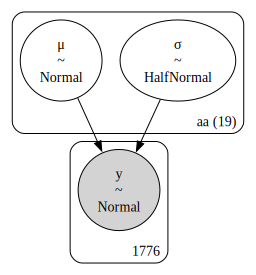

In [6]:
pm.model_to_graphviz(cs_nh)

In [7]:
with pm.Model(coords=coords) as cs_h:
    # hyper_priors
    μ_mu = pm.Normal('μ_mu', mu=0, sigma=10)
    μ_sd = pm.HalfNormal('μ_sd', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=10, dims="aa") 

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 

    idata_cs_h = pm.sample(random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_mu, μ_sd, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 210 seconds.


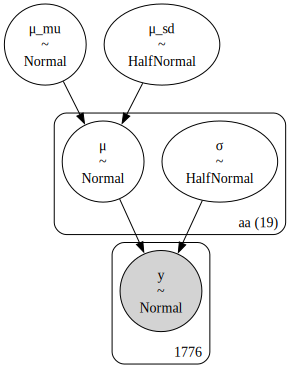

In [8]:
pm.model_to_graphviz(cs_h)

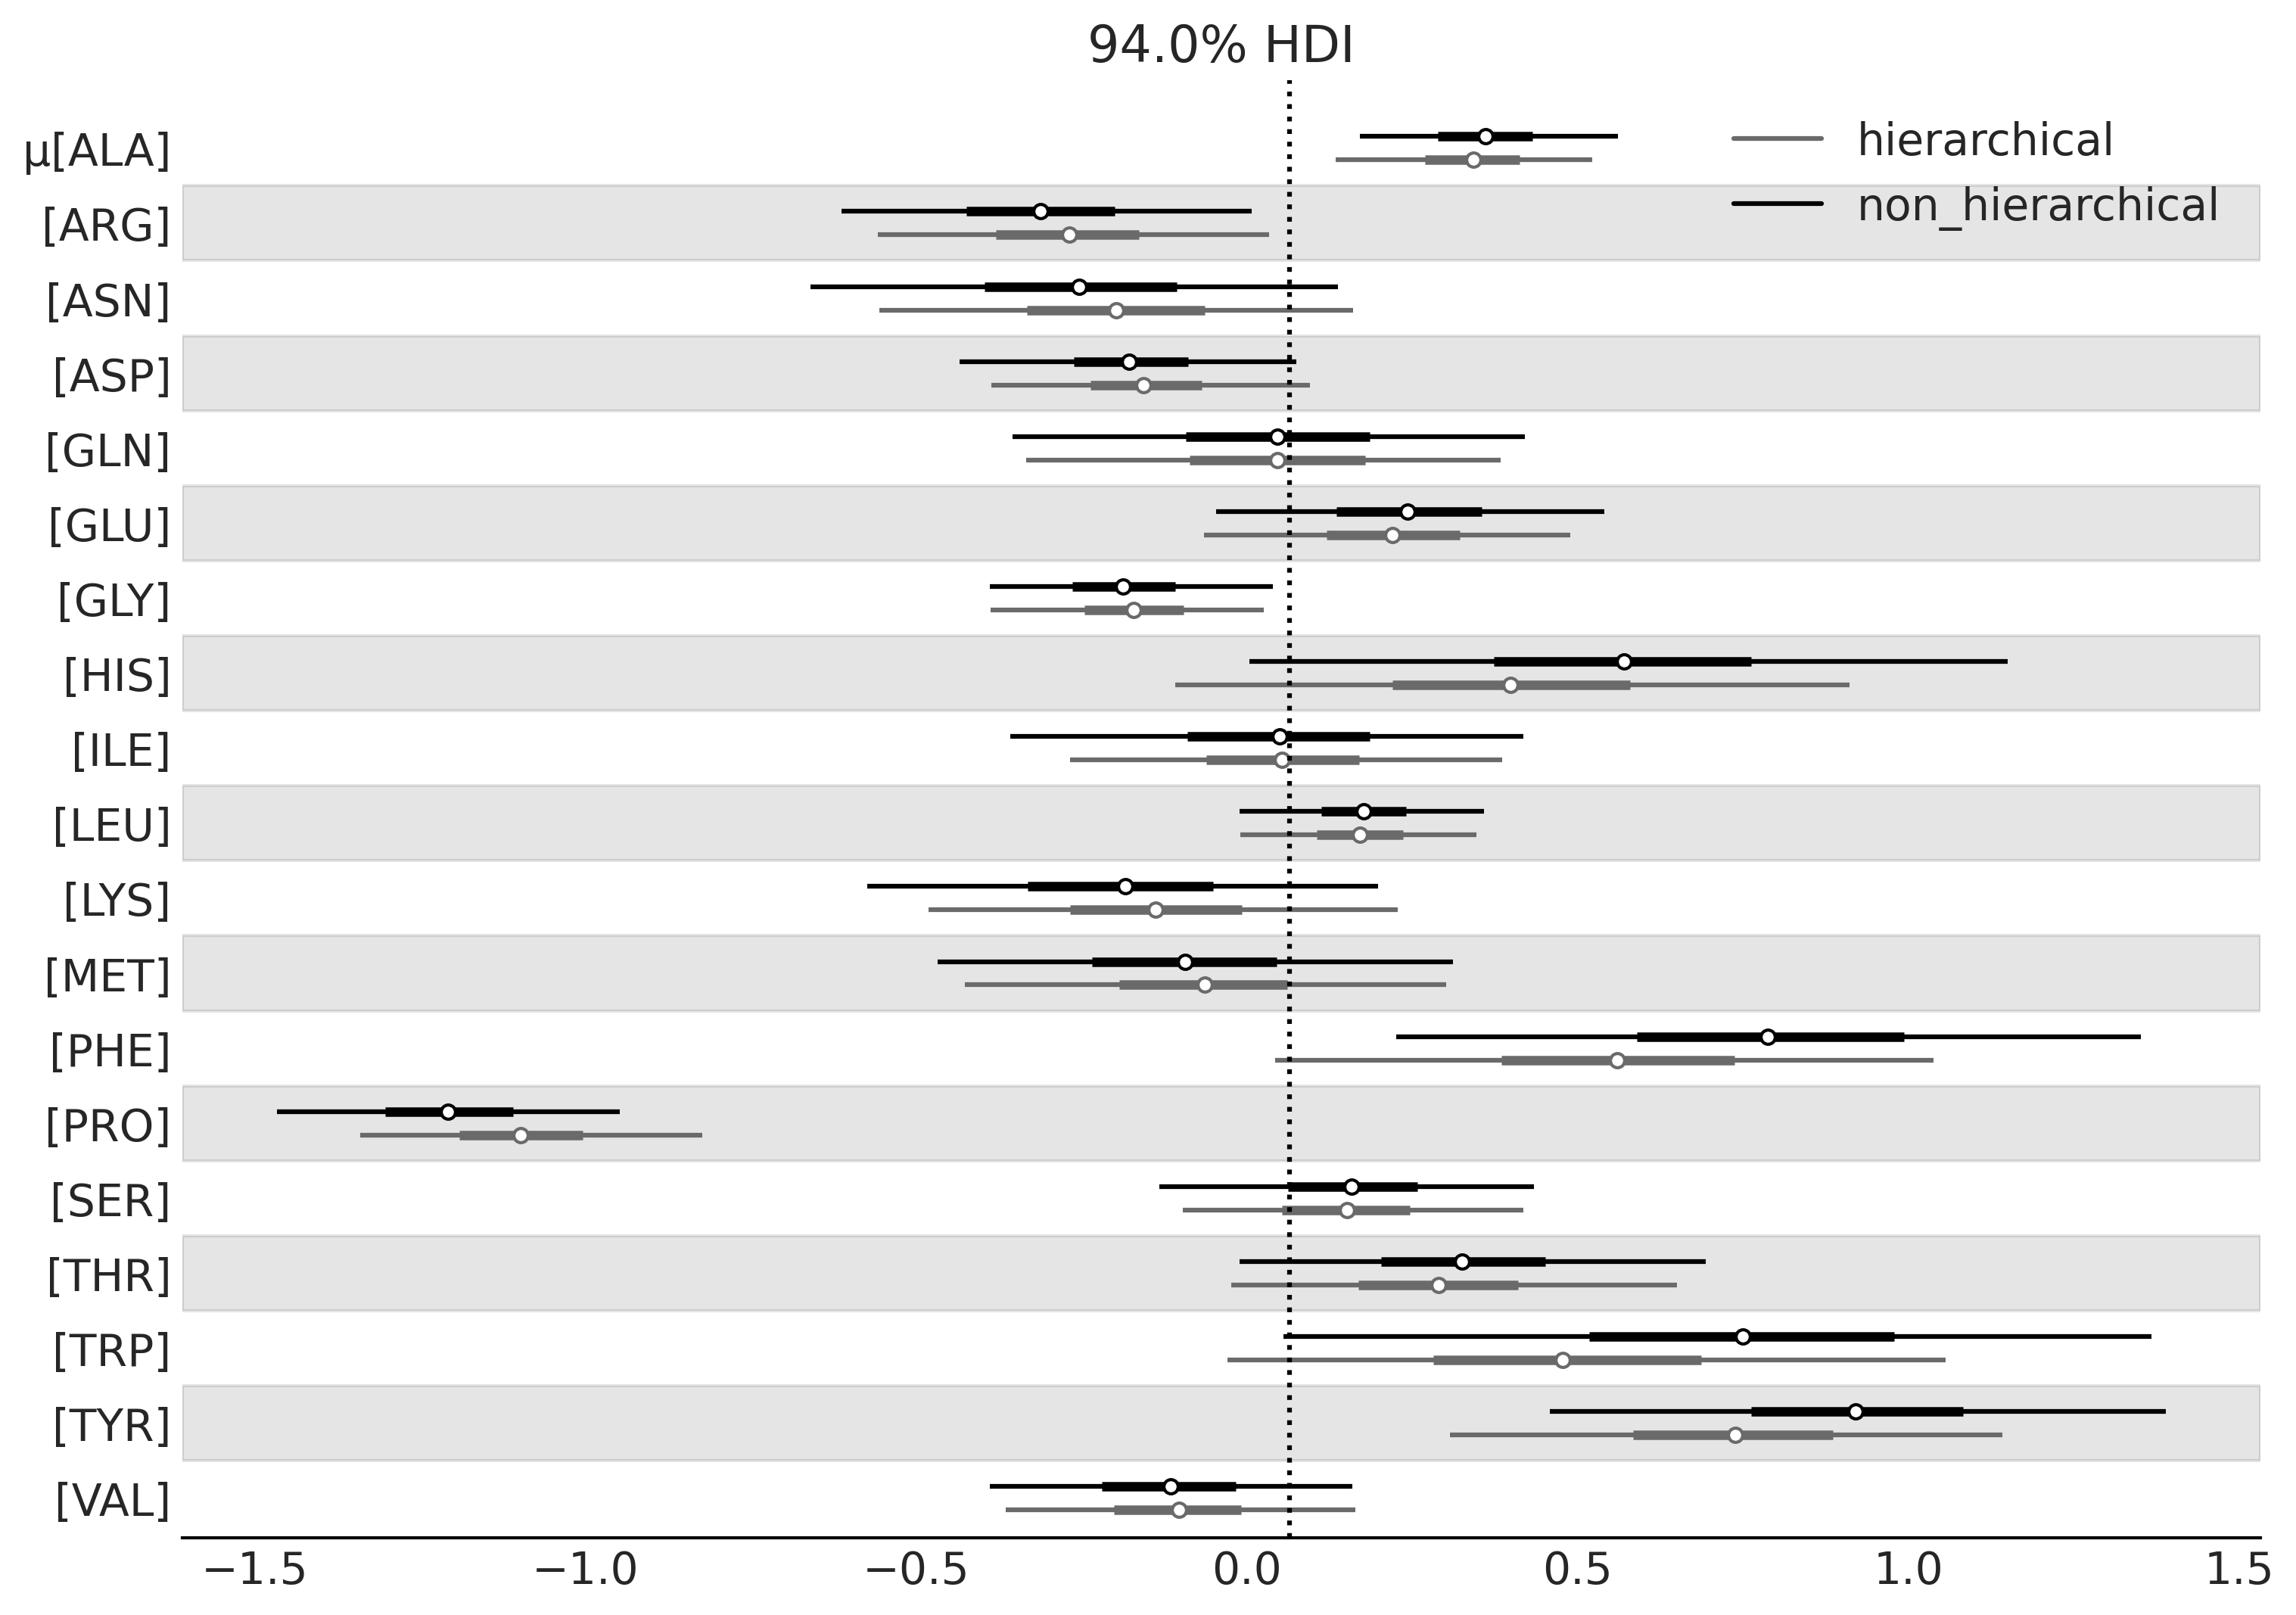

In [9]:
axes = az.plot_forest([idata_cs_nh, idata_cs_h], model_names=['non_hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, r_hat=False, ess=False, figsize=(10, 7),
                      colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

In [10]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

In [ ]:
with pm.Model() as model_h:
    # hypyerpriors
    μ = pm.Beta('μ', 1., 1.)
    ν = pm.HalfNormal('ν', 10)
    # prior
    θ = pm.Beta('θ', mu=μ, nu=ν, shape=len(N_samples))
    # likelihood
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    idata_h = pm.sample(random_seed=4591)

In [ ]:
az.summary(idata_h)

In [ ]:
az.plot_trace(idata_h)

In [ ]:
posterior = az.extract(idata_h, num_samples=100)
for sample in posterior[["μ", "ν"]].to_array().values.T:
    pz.Beta(mu=sample[0], kappa=sample[1]).plot_pdf(legend=None, color="C0", alpha=0.1, support=(0.01, 0.99), moments="m")

pz.Beta(mu=posterior["μ"].mean().item(), kappa=posterior["ν"].mean().item()).plot_pdf(legend=None, color="C0", moments="m")
plt.xlabel('$θ_{prior}$')

In [ ]:
football = pd.read_csv("data/football_players.csv", dtype={'position':'category'})
football

In [ ]:
pos_idx = football.position.cat.codes.values
pos_codes = football.position.cat.categories
n_pos = pos_codes.size
n_players = football.index.size

In [ ]:
coords = {"pos": pos_codes}
with pm.Model(coords=coords) as model_football:
    # Hyper parameters
    μ = pm.Beta('μ', 1.7, 5.8) 
    ν = pm.Gamma('ν', mu=125, sigma=50)

    
    # Parameters for positions
    μ_p = pm.Beta('μ_p',
                       mu=μ,
                       nu=ν,
                       dims = "pos")
    
    ν_p = pm.Gamma('ν_p', mu=125, sigma=50, dims="pos")
 
    # Parameter for players
    θ = pm.Beta('θ', 
                    mu=μ_p[pos_idx],
                    nu=ν_p[pos_idx])
    
    _ = pm.Binomial('gs', n=football.shots.values, p=θ, observed=football.goals.values)

    idata_football = pm.sample(draws=3000, target_accept=0.95, random_seed=4591)

In [ ]:
_, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
az.plot_posterior(idata_football, var_names='μ', ax=ax[0])
ax[0].set_title(r"Global mean")
az.plot_posterior(idata_football.posterior.sel(pos="FW"), var_names='μ_p', ax=ax[1])
ax[1].set_title(r"Forward position mean")
az.plot_posterior(idata_football.posterior.sel(θ_dim_0=1457), var_names='θ', ax=ax[2])
ax[2].set_title(r"Messi mean")

In [ ]:
az.plot_forest(idata_football, var_names=['μ_p'], combined=True, figsize=(12, 3))